# Locust Impacts from Space <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background
Can we use Sentinel-2 to see the impacts of locust plagues?

## Description

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
from datacube.utils import geometry
import xarray as xr
import datetime as dt
import os
# from deafrica_phenology import xr_phenology

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map, rgb
from time_buffer import time_buffer
import warnings
warnings.filterwarnings("ignore", "Mean of empty slice")
warnings.simplefilter("ignore", FutureWarning)

%load_ext autoreload
%autoreload 2

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='LOfS')

### Analysis parameters


In [3]:
# Set the vegetation proxy to use
veg_proxy = 'NDVI'
shp = 'data/Swarm_Master.shp'
date_filter = '2019-01-01' 
african_countries = 'data/african_countries.shp'

### Open and filter locust swarms in Africa

Looking for recent swarms, in African, with a high density of gregarious locusts

In [4]:
#Open shapefile of locust swarms
gdf = gpd.read_file(shp)

In [5]:
#convert date column to datetime objects
gdf['STARTDATE'] = pd.to_datetime(gdf['STARTDATE'], format='%Y-%m-%d')
gdf['FINISHDATE'] = pd.to_datetime(gdf['FINISHDATE'], format='%Y-%m-%d')

#mask dataset to swarms since 2020
mask = gdf['STARTDATE'] > date_filter
gdf = gdf.loc[mask]

In [6]:
#clip to Africa
afr = gpd.read_file(african_countries)
gdf = gpd.overlay(gdf, afr, how='intersection')

In [7]:
#Index for locations where density of gregarious grasshoppers==HIGH
gdf = gdf[gdf['GHPDENHI'] == 1.0]

### Turn remaining points into small polygons

This will help us index the datacube

In [8]:
#set radius (in metres) around points
radius = 500 # this = 100 hecates, same as plot size

#convert to equal area to set polygon size in metres
gdf = gdf.to_crs('EPSG:6933')

#create circle buffer around points, then find envelope
gdf['geometry'] = gdf['geometry'].buffer(radius).envelope

gdf = gdf.reset_index()

### Load Sentinel-2 data around locust swarm date

In [9]:
index = 0
buffer = '60 Days'

In [10]:
# Create a reusable query
query = {
    'measurements': ['red', 'green', 'blue', 'nir'],
    'resolution': (-10,10),
    'output_crs': 'epsg:6933'
}

# Get the geometry and time
geom = geometry.Geometry(gdf.iloc[index].geometry.__geo_interface__,
                         geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))

time = time_buffer(str(gdf.iloc[index]['STARTDATE'])[0:10],
                   buffer=buffer)

# Update dc query with geometry      
query.update({'geopolygon': geom, 'time':time}) 

# Load available data from Landsat 8
ds_locusts = load_ard(dc=dc,
              products=['s2_l2a'],
              group_by='solar_day',
              min_gooddata=0.75,
              **query,
              )


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 24 out of 45 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Loading 24 time steps


**Once the load is complete**, we can plot the data as a true-colour image using the `rgb` function.  

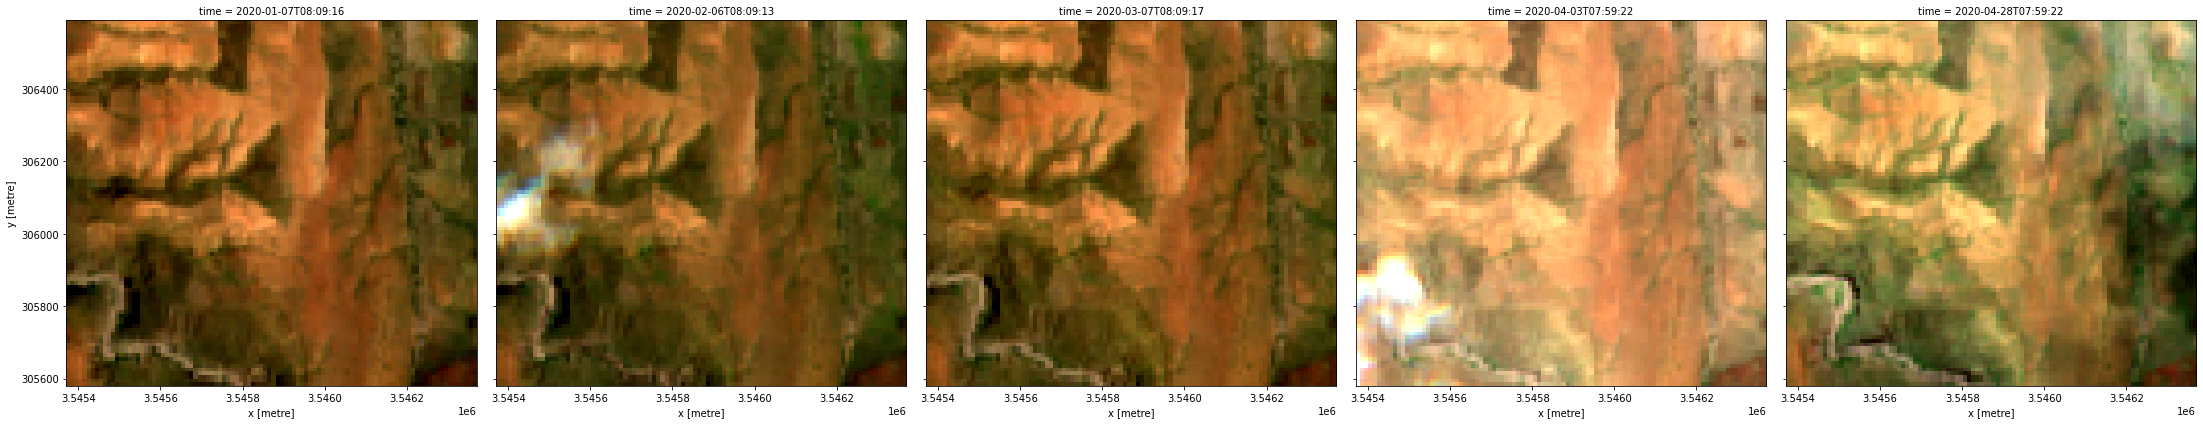

In [11]:
rgb(ds_locusts, index=[0,7,15,20,23], col_wrap=5)

### Now load Sentinel-2 data for the same time last year

In [12]:
print(str(gdf.iloc[index]['STARTDATE'])[0:10])

2020-03-03


In [13]:
#set date for same time but previous year to compare
previous_year = '2019-03-03'

In [14]:
# Create a reusable query
query = {
    'measurements': ['red', 'green', 'blue', 'nir'],
    'resolution': (-10,10),
    'output_crs': 'epsg:6933'
}

#new time
time = time_buffer(previous_year,
                   buffer=buffer)

# Update dc query with geometry      
query.update({'geopolygon': geom, 'time':time}) 

# Load available data from Landsat 8
ds_no_locusts = load_ard(dc=dc,
              products=['s2_l2a'],
              group_by='solar_day',
              min_gooddata=0.75,
              **query,
              )


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 40 out of 47 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Loading 40 time steps


### Compute band indices

In [15]:
ds_locusts = calculate_indices(ds_locusts, index=veg_proxy, collection='s2')
ds_no_locusts = calculate_indices(ds_no_locusts, index=veg_proxy, collection='s2')

## Compare locust swarm time-series with previous year


Interpolate data first so the timeseries is clean

In [16]:
ndvi_locusts = ds_locusts.NDVI.interpolate_na(dim='time', method='linear')
ndvi_locusts = ndvi_locusts.mean(['x', 'y']).resample(time='1W').interpolate('linear')

ndvi_no_locusts = ds_no_locusts.NDVI.interpolate_na(dim='time', method='linear')
ndvi_no_locusts = ndvi_no_locusts.mean(['x', 'y']).resample(time='1W').interpolate('linear')

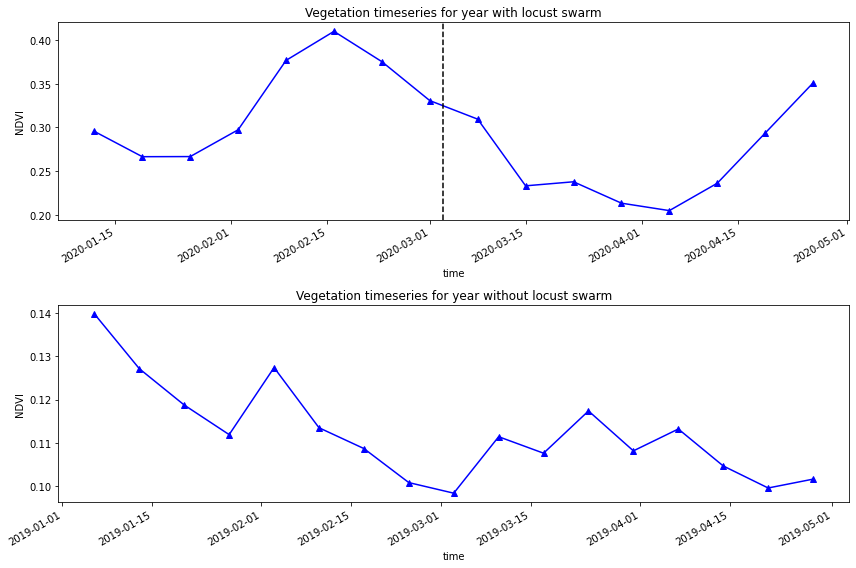

In [17]:
#plot the interpolated data
f,ax = plt.subplots(2,1,  figsize=(12,8))
ndvi_locusts.plot.line('b-^',ax=ax[0])
ax[0].set_title('Vegetation timeseries for year with locust swarm');
ax[0].axvline(gdf.iloc[index]['STARTDATE'], color='k', linestyle='--')

ndvi_no_locusts.plot.line('b-^',ax=ax[1])
ax[1].set_title('Vegetation timeseries for year without locust swarm')

f.tight_layout()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [18]:
print(datacube.__version__)

1.8.0


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)